In [0]:

!wget -nc http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!wget -nc http://www.cs.virginia.edu/~vicente/deeplearning/coco_images_small.zip
!unzip -qn annotations_trainval2014.zip
!unzip -qn coco_images_small.zip

--2020-02-21 23:28:27--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.27.44
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.27.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  16.5MB/s    in 16s     

2020-02-21 23:28:43 (15.1 MB/s) - ‘annotations_trainval2014.zip’ saved [252872794/252872794]

--2020-02-21 23:28:45--  http://www.cs.virginia.edu/~vicente/deeplearning/coco_images_small.zip
Resolving www.cs.virginia.edu (www.cs.virginia.edu)... 128.143.67.11
Connecting to www.cs.virginia.edu (www.cs.virginia.edu)|128.143.67.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2114808075 (2.0G) [application/x-compress]
Saving to: ‘coco_images_small.zip’

coco_images_small.z 100%[=================

#### Data Loader Definition

In [0]:
import torch.utils.data
import json, os
from PIL import Image
import torchvision.transforms as transforms

class CocoMultilabel(torch.utils.data.Dataset):
    def __init__(self, image_path, annotation_filepath, transform):
        super(CocoMultilabel, self).__init__()
        
        print('Loading data...')
        data = json.load(open(annotation_filepath, 'rb'))
        
        
        self.transform = transform
        
        self.image_path = image_path

        paired_id_names = [(image['id'], image['file_name']) for image in data['images']]
        paired_id_names = sorted(paired_id_names, key = lambda x: x[0]) 
        self.image_names = [img_name for (img_id, img_name) in paired_id_names]
        self.image_ids = [img_id for (img_id, img_name) in paired_id_names]
        
        paired_id_names = [(category['id'], category['name']) for category in data['categories']]
        paired_id_names = sorted(paired_id_names, key = lambda x: x[0])
        self.classes = [cat_name for (cat_id, cat_name) in paired_id_names]
        classes_ids = [cat_id for (cat_id, cat_name) in paired_id_names]
        class_id_to_index = {category_id : i for (i, category_id) in enumerate(classes_ids)}
        
        # Map images to annotations.
        image_anns = dict()
        for ann in data['annotations']:
            if ann['image_id'] not in image_anns:
                image_anns[ann['image_id']] = set()
            image_anns[ann['image_id']].add(ann['category_id'])
        
        # Precompute labels as 1-0 vectors.
        self.image_labels = torch.zeros(len(self.image_ids), len(self.classes))
        for (i, image_id) in enumerate(self.image_ids):
            if image_id in image_anns: # Apparently some images have no labels.
                anns = list(image_anns[image_id])
                anns = torch.tensor([class_id_to_index[cat_id] for cat_id in anns])
                self.image_labels[i, anns] = 1 
                
        print('...loaded.')
    
    def __getitem__(self, index):
        image_name = self.image_names[index]
        img_ = Image.open(open(os.path.join(self.image_path, image_name), 'rb'))
        img_ = img_.convert("RGB")
        if self.transform:
            img_ = self.transform(img_)
            #img_ = self.transform(img_).unsqueeze(0)
        label_ = self.image_labels[index, :]
        return img_, label_, image_name
    
    def __len__(self):
        return len(self.image_ids)

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor




train_transform = transforms.Compose(
    [transforms.Resize(256),  # 1. Resize smallest side to 256.
     transforms.RandomCrop(224), # 2. Crop random square of 224x224 pixels.
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(), # 3. Convert to pytorch tensor.
     transforms.Normalize(mean = [0.485, 0.456, 0.406],  # normalize.
                          std = [0.229, 0.224, 0.225])])

test_transform = transforms.Compose(
    [transforms.Resize(256),  # 1. Resize smallest side to 256.
     transforms.CenterCrop(224), # 2. Crop center square of 224x224 pixels.
     transforms.ToTensor(), # 3. Convert to pytorch tensor.
     transforms.Normalize(mean = [0.485, 0.456, 0.406],  # normalize.
                          std = [0.229, 0.224, 0.225])])


train_dataset = CocoMultilabel('coco_256x256/train', 'annotations/instances_train2014.json', train_transform)
val_dataset = CocoMultilabel('coco_256x256/val', 'annotations/instances_val2014.json', test_transform)

Loading data...
...loaded.
Loading data...
...loaded.


My label:  tensor([1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
torch.Size([80])


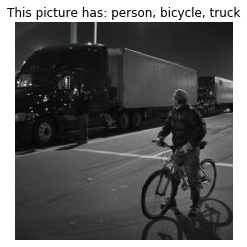

In [0]:
import matplotlib.pyplot as plt


my_image, my_label, name = val_dataset[2348]
print("My label: ", my_label)
print(my_label.size())
plt.figure()
labels = [train_dataset.classes[id] for id in list(my_label.nonzero().flatten())]
plt.title("This picture has: " + ", ".join(labels))
for t, m, s in zip(my_image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
  t.mul_(s).add_(m)


plt.imshow(my_image.transpose(0,2).transpose(0,1));
plt.grid(False); plt.axis('off');

Train-epoch 0. Iteration 00100 / 02587, Avg-Loss: 0.2880, Accuracy: 0.2078
Train-epoch 0. Iteration 00200 / 02587, Avg-Loss: 0.2153, Accuracy: 0.2368
Train-epoch 0. Iteration 00300 / 02587, Avg-Loss: 0.1877, Accuracy: 0.2501
Train-epoch 0. Iteration 00400 / 02587, Avg-Loss: 0.1726, Accuracy: 0.2599
Train-epoch 0. Iteration 00500 / 02587, Avg-Loss: 0.1629, Accuracy: 0.2689
Train-epoch 0. Iteration 00600 / 02587, Avg-Loss: 0.1559, Accuracy: 0.2762
Train-epoch 0. Iteration 00700 / 02587, Avg-Loss: 0.1506, Accuracy: 0.2831
Train-epoch 0. Iteration 00800 / 02587, Avg-Loss: 0.1464, Accuracy: 0.2896
Train-epoch 0. Iteration 00900 / 02587, Avg-Loss: 0.1427, Accuracy: 0.2970
Train-epoch 0. Iteration 01000 / 02587, Avg-Loss: 0.1396, Accuracy: 0.3043
Train-epoch 0. Iteration 01100 / 02587, Avg-Loss: 0.1369, Accuracy: 0.3114
Train-epoch 0. Iteration 01200 / 02587, Avg-Loss: 0.1344, Accuracy: 0.3181
Train-epoch 0. Iteration 01300 / 02587, Avg-Loss: 0.1323, Accuracy: 0.3244
Train-epoch 0. Iteration 

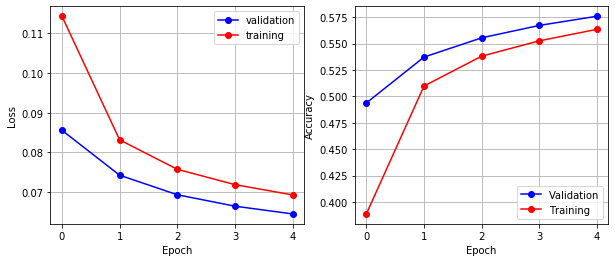

In [0]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
CUDA_LAUNCH_BLOCKING="1"


def train_model(model, loss_fn, batchSize, trainset, valset, optimizer, num_epochs):
  
  train_loader = torch.utils.data.DataLoader(dataset = trainset,
                                              batch_size = batchSize,
                                              shuffle = True)
  val_loader = torch.utils.data.DataLoader(dataset = valset,
                                            batch_size = batchSize,
                                            shuffle = False) # No need.
  
  N = num_epochs

  train_accuracies = []; val_accuracies = []
  train_losses = []; val_losses = []

  model = model.cuda()
  loss_fn = loss_fn.cuda()

  for epoch in range(0, N):
      correct = 0.0
      cum_loss = 0.0

      model.train()
      for (i, (inputs, labels, names)) in enumerate(train_loader):
          inputs = inputs.cuda()
          labels = labels.cuda()

          # Forward pass. (Prediction stage)
          scores = model(inputs.float())
          #scores = sigmoid(scores)
        #   print("scores: ", scores)
        #   print(scores.size())
        #   print("scores[0,:]", scores[0,:])
        #   print("scores[1,:]", scores[1,:])
          
          #scores = nn.Sigmoid(scores)
          
          loss = loss_fn(scores, labels)

          #loss = loss_fn(scores, torch.max(labels, 1)[1])


          #max_scores, max_labels = scores.max(1)
          #max_scores, max_labels = scores.(3, dim=1, largest=True, sorted=True)
          #correct += (max_labels == labels).sum.item()

          top3, top3index = torch.topk(scores, 3, 1)
          rowList = torch.arange(labels.size()[0]).unsqueeze(1)     
          correct += (labels[rowList, top3index].sum().item())/3

          cum_loss += loss.item()
          optimizer.zero_grad()
          #Backward pass. (Gradient computation stage)
          loss.backward()

          # Parameter updates (SGD step) -- if done with torch.optim!
          optimizer.step()

          if (i + 1) % 100 == 0:
              print('Train-epoch %d. Iteration %05d / %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                    (epoch, i + 1, len(train_loader), cum_loss / (i + 1), correct / ((i + 1) * batchSize)))
      train_accuracies.append(correct / len(trainset))
      train_losses.append(cum_loss / (i + 1))   

      # Make a pass over the validation data.
      correct = 0.0
      cum_loss = 0.0
      model.eval()
      for (i, (inputs, labels, names)) in enumerate(val_loader):
          inputs = inputs.cuda()
          labels = labels.cuda()

          # Forward pass. (Prediction stage)
          scores = model(inputs.float())
          cum_loss += loss_fn(scores, labels).item()
          top3, top3index = torch.topk(scores, 3, 1)
          rowList = torch.arange(labels.size()[0]).unsqueeze(1)     
          correct += (labels[rowList, top3index].sum().item())/3

      val_accuracies.append(correct / len(valset))
      val_losses.append(cum_loss / (i + 1))
      
      print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' % 
            (epoch, cum_loss / (i + 1), correct / len(valset)))
  return train_accuracies, val_accuracies,train_losses, val_losses


coco_model = models.resnet50(pretrained = True)
coco_model.fc = nn.Linear(2048, len(train_dataset.classes))
#print(coco_model)

batchSize = 32
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = optim.SGD(coco_model.parameters(), lr = 3e-3, momentum = 0.9, weight_decay=1e-5)

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

train_accuracies,val_accuracies,train_losses,val_losses = train_model(coco_model, loss_fn, batchSize, train_dataset, val_dataset, optimizer, 5)

torch.save(coco_model.state_dict(), 'coco_model_weights.pth')   




plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(val_losses, "bo-", label="val-loss")
plt.plot(train_losses, "ro-", label="train-loss")
plt.grid("on")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["validation", "training"], loc="upper right")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, "bo-", label="val-acc")
plt.plot(train_accuracies, "ro-", label="train-acc")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.grid("on")
plt.legend(["Validation", "Training"], loc="lower right")
plt.show()

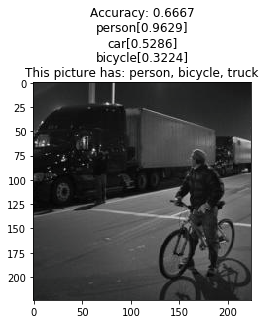

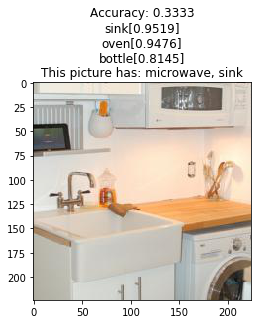

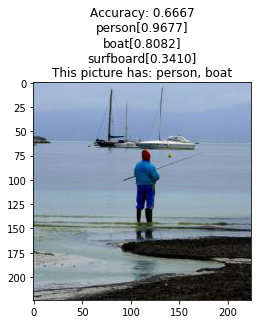

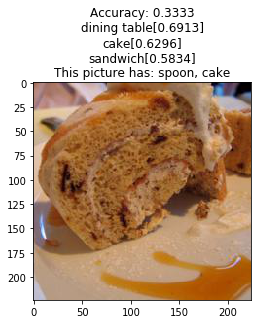

In [0]:
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt



coco_model = models.resnet50(pretrained = True)
coco_model.fc = nn.Linear(2048, len(train_dataset.classes))
coco_model.eval()

coco_model.load_state_dict(torch.load('coco_model_weights .pth'))
sigmoid = nn.Sigmoid()
imgList = [2348, 13134, 22313, 4123]

for i in range(4):
    my_image, my_label,_ = val_dataset[imgList[i]]  
    scores = coco_model(my_image.unsqueeze(0))
    plt.figure()
    correct = 0
    top3, top3index = torch.topk(scores, 3,)  
    top3 = sigmoid(top3)
    correct += (my_label[top3index].sum().item())/3
    
    labels = [val_dataset.classes[id] for id in list(my_label.nonzero().flatten())]
    unnorm = UnNormalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    my_image = unnorm(my_image)
    
    index = top3index[0]
    pre_labels = [val_dataset.classes[id] for id in index]
    pre_scores=[]
    for i in range(3):
       #print("Prediction:", pre_labels[i],"[", top3[0][i].item(), "]")
       pre_score_con = pre_labels[i] +"["+ str("%.4f"%top3[0][i].item())+"]"
       pre_scores.append(str(pre_score_con))
    plt.title("Accuracy: " + ("%.4f"%correct)+"\n"+ "\n".join(pre_scores)+"\n"+
                "This picture has: " + ", ".join(labels))
    plt.imshow(my_image.transpose(0,2).transpose(0,1));